<a href="https://colab.research.google.com/github/Zulfa-Varvani/ML-things/blob/main/water_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

Saving water.csv to water (1).csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['water.csv']))
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [5]:
df.isna().sum()
#15% of pH values missing
#24% of sulfate values missing
#5% of trihalomethanes missing

#why are they missing though? what values need to be imputed?
#pH is very important, need to ensure values are between 6.5 - 8.5

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
df['ph'].between(6.5,8.5).any()
#all values are between 6.5 and 8.5 <-- follow guidelines and is safe for imputing missing values
#trihalomethanes are also safe for imputing

True

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

"""
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)
"""

x = df.drop('Potability', axis=1)
y = df.Potability

#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [14]:
#see if we can drop columns with missing values
#both train and test set have same columns that are missing, it is safe to drop those columns
"""
cols_missing = ['ph', 'Sulfate', 'Trihalomethanes']

train_miss = x_train.drop(cols_missing, axis=1)
test_miss = x_test.drop(cols_missing,axis=1)

print(f'MAE from dropping: {score_dataset(train_miss, test_miss, y_train, y_test)*1000}')
"""

MAE from dropping: 387.1951219512195


In [15]:
#now we will impute any missing values with SimpleImputer
"""
from sklearn.impute import SimpleImputer

imp = SimpleImputer()
imp_train = pd.DataFrame(imp.fit_transform(x_train))
imp_test = pd.DataFrame(imp.transform(x_test))

imp_train.columns = x_train.columns
imp_test.columns = x_test.columns

print(f'MAE from imputing: {score_dataset(imp_train, imp_test, y_train, y_test)*1000}')
"""
#imputing these missing values give a better score for MAE, therefore we will impute the missing values
#from previous assessment, imputing is also safe to do

MAE from imputing: 356.7073170731707


In [17]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer()
x_imp = pd.DataFrame(imp.fit_transform(x))
x_imp.columns = x.columns

x_imp.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

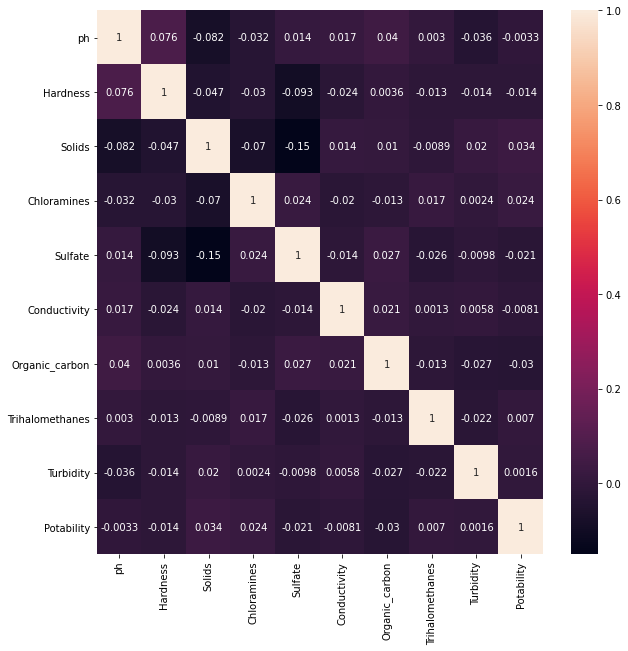

In [23]:
data = pd.concat([x_imp,y], axis=1)
#data.head()
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True)

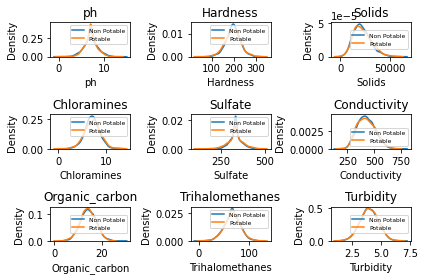

In [20]:
non = data.query('Potability == 0')
pot = data.query('Potability == 1')

for ax,col in enumerate(data.columns[:9]):
  plt.subplot(3,3,ax+1)
  plt.title(f'{col}')
  sns.kdeplot(x=non[col], label='Non Potable')
  sns.kdeplot(x=pot[col], label='Potable')
  plt.legend(prop=dict(size=6))

plt.tight_layout()

In [21]:
#correlation between features
cor = data.drop('Potability', axis=1).corr()
cor
#solids and sulfate might have the highest correlation, but overall there is very little correlation between the features

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,1.000000,0.075833,-0.081884,-0.031811,0.014403,0.017192,0.040061,0.002994,-0.036222
Hardness,0.075833,1.000000,-0.046899,-0.030054,-0.092766,-0.023915,0.003610,-0.012690,-0.014449
Solids,-0.081884,-0.046899,1.000000,-0.070148,-0.149840,0.013831,0.010242,-0.008875,0.019546
Chloramines,-0.031811,-0.030054,-0.070148,1.000000,0.023791,-0.020486,-0.012653,0.016627,0.002363
Sulfate,0.014403,-0.092766,-0.149840,0.023791,1.000000,-0.014059,0.026909,-0.025605,-0.009790
Conductivity,0.017192,-0.023915,0.013831,-0.020486,-0.014059,1.000000,0.020966,0.001255,0.005798
Organic_carbon,0.040061,0.003610,0.010242,-0.012653,0.026909,0.020966,1.000000,-0.012976,-0.027308
Trihalomethanes,0.002994,-0.012690,-0.008875,0.016627,-0.025605,0.001255,-0.012976,1.000000,-0.021502
Turbidity,-0.036222,-0.014449,0.019546,0.002363,-0.009790,0.005798,-0.027308,-0.021502,1.000000


In [32]:
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(x_imp, y, test_size=0.2, random_state=42)
#x_train.head()
#normalize dataset
std_scl = StandardScaler()
std_scl.fit(x_train)
x_train = std_scl.transform(x_train)
x_test = std_scl.transform(x_test)

In [31]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=2, random_state=42)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test,pred)*100}%')

Accuracy: 68.14024390243902%


A lot can be said about this dataset. For example, the author did not provide the source of the dataset. In addition, it seems as though the dataset may have some errors, by WHO's standard, the accepted TDS level is 300 ppm, but the dataset shows 19598.86 ppm as an example of potable water. Finally, in visualizing the data as given, we can see that the distribution of potable and non-potable water is very similar, almost as though the dataset has been tampered with?